# Neural Network Collaborative Filtering

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil

from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import RandomUniform, he_normal, he_uniform
from sklearn.model_selection import train_test_split

%matplotlib inline

In [7]:
train = pd.read_csv("data\\train-plays.csv").drop(columns=["norm_amount", "amount"])
test = pd.read_csv("data\\test-plays.csv").drop(columns=["norm_amount", "amount"])
game_coding = pd.read_csv("data\\game-coding.csv")

## Format training data

In [8]:
train['played'] = 1
test['played'] = 1

In [9]:
rand_users = np.random.randint(0, train.user_id.unique().size, train.shape[0] * 10)
rand_games = np.random.randint(0, train.game_id.unique().size, train.shape[0] * 10)
neg_train = pd.DataFrame({"user_id":rand_users, "game_id":rand_games})
neg_train

,user_id,game_id
0,845,391
1,603,248
2,1141,363
3,291,1026
4,1109,837
...,...,...
393615,222,248
393616,346,1048
393617,270,223
393618,13,677


In [10]:
train = train.merge(neg_train, how="outer", on=['user_id', 'game_id'])
train.played = np.where(train.played != 1, 0, 1)
train = train.sample(frac=1.0)
train

,game_id,user_id,played
408098,765,766,0
106562,807,137,0
310973,84,877,0
142899,16,219,0
406729,538,1005,0
...,...,...,...
62227,289,946,0
357650,482,308,0
264292,517,1006,0
246501,551,375,0


In [11]:
print(train[train.played == 0].shape[0]/train.shape[0])
print(train[train.played == 1].shape[0]/train.shape[0])

0.9030152632027176
0.09698473679728234


## Neural Network Construction

In [12]:
# number of latent factors
n_latent_factors = 16

In [13]:
# game input and embedding
game_input = keras.layers.Input(shape=[1], name='Game')
game_embedding = keras.layers.Embedding(train.game_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='Game-Embedding')(game_input)
game_vec = keras.layers.Flatten(name='FlattenGames')(game_embedding)

In [14]:
# user input and embedding
user_input = keras.layers.Input(shape=[1], name='User')
user_embedding = keras.layers.Embedding(train.user_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

In [15]:
concat = keras.layers.concatenate([game_vec, user_vec])
 
mlp = concat
for i in [4, 2, 1, 0]:
    if i == 0:
      mlp = Dense(1, activation='sigmoid', kernel_initializer='glorot_normal',
                  name="output")(mlp)
    else:
      mlp = Dense(n_latent_factors * i, activation='relu', 
                  kernel_initializer='he_uniform')(mlp)
      if i == 4:
        mlp = BatchNorm alization()(mlp)
      mlp = Dropout(0.2)(mlp)
 
model = Model(inputs=[user_input, game_input], outputs=[mlp])
 
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Game (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Game-Embedding (Embedding)      (None, 1, 20)        20980       Game[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 20)        25060       User[0][0]                       
______________________________________________________________________________________________

## Model Training

In [17]:
history = model.fit([train.user_id, train.game_id], train.played, epochs=100)

Train on 422716 samples
Epoch 1/100
422716/422716 [==============================] - 52s 124us/sample - loss: 0.4954 - binary_accuracy: 0.8327
Epoch 2/100
422716/422716 [==============================] - 51s 120us/sample - loss: 0.3858 - binary_accuracy: 0.8975
Epoch 3/100
422716/422716 [==============================] - 53s 126us/sample - loss: 0.3558 - binary_accuracy: 0.9018
Epoch 4/100
117504/422716 [=======>......................] - ETA: 38s - loss: 0.3526 - binary_accuracy: 0.9015

KeyboardInterrupt: 

Text(0, 0.5, 'Training Error')

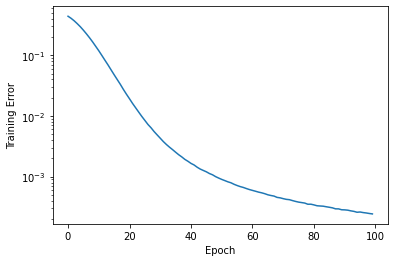

In [18]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

## Model Analysis